In [ ]:
import warnings
warnings.filterwarnings("ignore")

# installing efficientNet source code
!pip install -U git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-bwo5n3i9
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-bwo5n3i9
  Created wheel for efficientnet: filename=efficientnet-1.0.0-cp36-none-any.whl size=17686 sha256=dc871f4617c06f3b394ac18641cfc34c2123e67f329dff2e4b048543cf3f2ada
  Stored in directory: /tmp/pip-ephem-wheel-cache-3w9ns68o/wheels/64/60/2e/30ebaa76ed1626e86bfb0cc0579b737fdb7d9ff8cb9522663a
Successfully built efficientnet


In [ ]:
import keras
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, BatchNormalization, Flatten
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
import efficientnet.keras as enet


Using TensorFlow backend.


In [ ]:
# loading Cifar-10 dataset

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

170500096/170498071 [==============================] - 4s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [ ]:
# Swish defination
from keras.backend import sigmoid

class SwishActivation(Activation):
    
    def __init__(self, activation, **kwargs):
        super(SwishActivation, self).__init__(activation, **kwargs)
        self.__name__ = 'swish_act'

def swish_act(x, beta = 1):
    return (x * sigmoid(beta * x))

from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
get_custom_objects().update({'swish_act': SwishActivation(swish_act)})

In [ ]:
# loading B0 pre-trained on ImageNet without final aka fiature extractor
model = enet.EfficientNetB0(include_top=False, input_shape=(32,32,3), pooling='avg', weights='imagenet')

# building 2 fully connected layer 
x = model.output

x = BatchNormalization()(x)
x = Dropout(0.7)(x)

x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation(swish_act)(x)
x = Dropout(0.5)(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = Activation(swish_act)(x)

# output layer
predictions = Dense(10, activation="softmax")(x)

model_final = Model(inputs = model.input, outputs = predictions)

model_final.summary()











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
16809984/16804768 [==============================] - 1s 0us/step

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 16, 16, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 16, 16, 32)   128         stem_conv[0][0]                  
__________________________________________________________________________________________________


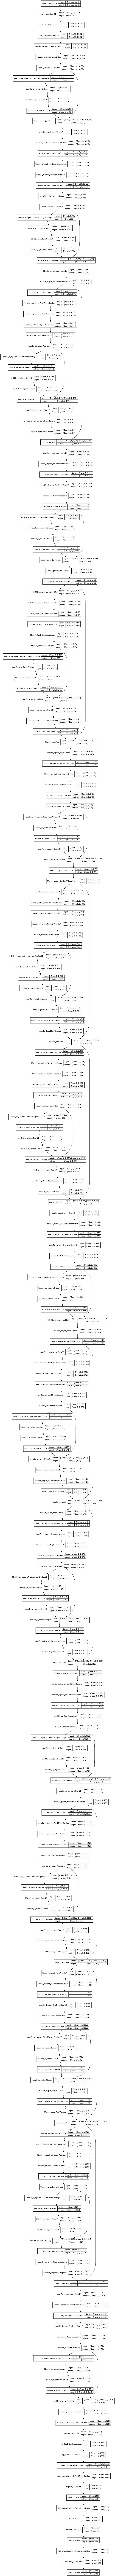

In [ ]:
# ploting keras model for visualization

from keras.utils.vis_utils import plot_model
plot_model(model_final, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# model compilation
model_final.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.0001),
              metrics=['accuracy'])

mcp_save = ModelCheckpoint('EnetB0_CIFAR10_TL.h5', save_best_only=True, monitor='val_acc')
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, verbose=1,)

#print("Training....")
model_final.fit(x_train, y_train,
              batch_size=32,
              epochs=10,
              validation_split=0.1,
              callbacks=[mcp_save, reduce_lr],
              shuffle=True,
              verbose=1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/10
45000/45000 [==============================] - 122s 3ms/step - loss: 1.0269 - acc: 0.6489 - val_loss: 0.7952 - val_acc: 0.7366
Epoch 2/10
45000/45000 [==============================] - 106s 2ms/step - loss: 0.8544 - acc: 0.7113 - val_loss: 0.6767 - val_acc: 0.7792
Epoch 3/10
45000/45000 [==============================] - 106s 2ms/step - loss: 0.7440 - acc: 0.7487 - val_loss: 0.6249 - val_acc: 0.7990
Epoch 4/10
45000/45000 [==============================] - 104s 2ms/step - loss: 0.6661 - acc: 0.7779 - val_loss: 0.5820 - val_acc: 0.8112
Epoch 5/10
45000/45000 [==============================] - 104s 2ms/step - loss: 0.5932 - acc: 0.8010 - val_loss: 0.5523 - val_acc: 0.8152
Epoch 6/10
45000/45000 [==============================] - 107s 2ms/step - loss: 0.5369 - acc: 0.8209 - val_loss: 0.5306 - val_acc: 0.8226
Epoch 7/10
45000/45000 [==============================] - 107s 2ms/step - loss: 0.4801 - acc: 0.8394 - val_loss: 0.5154 - v

In [ ]:
_, acc = model_final.evaluate(x_test, y_test)

10000/10000 [==============================] - 7s 691us/step


In [ ]:
print("Test Accuracy: {}%".format(acc*100))

Test Accuracy: 82.42%


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

test_pred = model_final.predict(x_test)

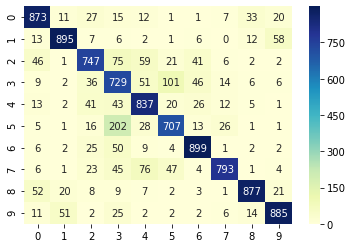

In [ ]:
import numpy as np

ax = sns.heatmap(confusion_matrix(np.argmax(y_test, axis=1),np.argmax(test_pred, axis=1)), cmap="YlGnBu",annot=True,fmt="d")

In [ ]:
def mbConv_block(input_data, block_arg):
    """Mobile Inverted Residual block along with Squeeze and Excitation block."""
    kernel_size = block_arg.kernel_size
    num_repeat= block_arg.num_repeat
    input_filters= block_arg.input_filters
    output_filters= output_filters.kernel_size
    expand_ratio= block_arg.expand_ratio
    id_skip= block_arg.id_skip
    strides= block_arg.strides
    se_ratio= block_arg.se_ratio
    # expansion phase
    expanded_filters =  input_filters * expand_ratio
    x = Conv2D(expanded_filters, 1,  padding='same',  use_bias=False)(input_data)
    x = BatchNormalization()(x)
    x = Activation(swish_activation)(x)
    # Depthwise convolution phase
    x = DepthwiseConv2D(kernel_size, strides,  padding='same',  use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation(swish_activation)(x)
    # Squeeze and excitation phase
    se = GlobalAveragePooling2D()(x)
    se = Reshape((1, 1, expanded_filters ))(x)
    squeezed_filters = max (1, int(input_filters * se_ratio))
    se = Conv2D(squeezed_filters , 1, activation=swish_activation, padding='same')(se)
    se = Conv2D(expanded_filters, 1, activation=’sigmoid’, padding='same')(se)
    x = multiply([x, se])
    # Output phase
    x = Conv2D(output_filters, 1, padding='same', use_bias=False)
    x = BatchNormalization()(x)
    return x
